In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2

# Set your base path
base_path = '/content/drive/MyDrive/Currency'

# Loop through both 'real' and 'fake' folders
for label_folder in ['real', 'fake']:
    folder_path = os.path.join(base_path, label_folder)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Read the image
        img = cv2.imread(file_path)
        if img is not None:
            # Create new file name with .jpg extension
            new_name = os.path.splitext(file_name)[0] + ".jpg"
            new_path = os.path.join(folder_path, new_name)

            # Save as .jpg
            cv2.imwrite(new_path, img)

            # Optionally, delete the old file (not .jpg)
            if not file_name.lower().endswith('.jpg'):
                os.remove(file_path)

print("All images converted to .jpg format.")


All images converted to .jpg format.


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm

# Set path to your dataset
data_path = '/content/drive/MyDrive/Currency'

IMG_SIZE = 128  # Resize all images to 128x128
X = []
y = []

for label, folder in enumerate(['real', 'fake']):
    folder_path = os.path.join(data_path, folder)
    for img_file in tqdm(os.listdir(folder_path), desc=f'Loading {folder} images'):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)
print("Loaded:", X.shape, y.shape)


Loading fake images: 100%|██████████| 2119/2119 [00:51<00:00, 40.78it/s] 


Loaded: (3878, 128, 128, 3) (3878,)


In [ ]:
from sklearn.model_selection import train_test_split

X = X / 255.0  # Normalize pixel values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input

def build_feature_extractor():
    inp = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    model = Model(inputs=inp, outputs=x)
    return model

cnn_model = build_feature_extractor()

In [ ]:
# Extract features using CNN
X_train_feat = cnn_model.predict(X_train)
X_test_feat = cnn_model.predict(X_test)

print("Feature shapes:", X_train_feat.shape, X_test_feat.shape)


97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step
Feature shapes: (3102, 57600) (776, 57600)


 CNN + SVM Accuracy: 0.8685567010309279
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       365
           1       0.87      0.88      0.88       411

    accuracy                           0.87       776
   macro avg       0.87      0.87      0.87       776
weighted avg       0.87      0.87      0.87       776



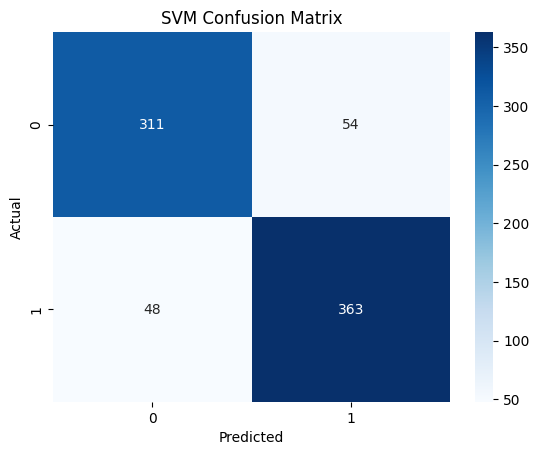

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_feat, y_train)

# Predict
svm_preds = svm.predict(X_test_feat)

# Evaluate
print(" CNN + SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, svm_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_feat, y_train)

# Predict
xgb_preds = xgb.predict(X_test_feat)

# Evaluate
print("🎯 CNN + XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
def predict_image(img_path, extractor_model, classifier_model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # (1, 128, 128, 3)

    features = extractor_model.predict(img)  # (1, 57600)
    pred = classifier_model.predict(features)

    if hasattr(classifier_model, "predict_proba"):
        prob = classifier_model.predict_proba(features)[0]
        confidence = np.max(prob) * 100
    else:
        confidence = None

    result = "Real" if pred[0] == 0 else "Fake"
    return f"Prediction: {result} (Confidence: {confidence:.2f}%)" if confidence else f"Prediction: {result}"

# Test Example
print(predict_image('/content/drive/MyDrive/Currency/fake/fake1.jpg', cnn_model, xgb))  # or use svm instead of xgb